#### Import required modules & scripts

In [1]:
PATH_SCRIPTS= r'../src/scripts'
PATH_MODULES= r'/exports/reum/tdmaarseveen/modules/' # unused
PATH_FILES = r"../../EMR_mining/output_files/"

import sys
sys.path.append(PATH_SCRIPTS)
sys.path.append(r'../src/1_emr_scripts')
#sys.path.append(PATH_MODULES)

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import Preprocessing as func
#import medExtract as me
# ug/l is the same as g/l
from sklearn import __version__ as vers
print(vers)

## #1. Process lab values

In [31]:
import pandas as pd
import importlib as imp
imp.reload(func)
df_lab = pd.read_csv(r'../data/2_preprocessing/DF_Lab_firstCon.csv', sep='|', index_col=0) 
#df_lab = pd.read_csv(r'../data/1_raw/DF_Lab_values.csv', sep='|', index_col=0) #, header=None

# Infer Max cut-off as value for CRP and BSE
#c_result = 'valueQuantity_value' # 'uitslag_value'
#c_alt = 'valueString'
#c_desc = 'code_display_original'

df_lab = df_lab.rename(columns={'patnr' : 'patient_id', 
                                'issued' : 'Monster_Afname_Datumtijd', 
                                'valueQuantity_value': 'uitslag_value', 
                                'code_display_original' : 'test_naam_omschrijving', 
                                'valueString' : 'uitslag_text',
                                'valueQuantity_code_original' : 'uitslag_unit'})

df_lab['uitslag_value'] = df_lab.apply(lambda x: func.use_max_lab(x, col_test='BSE'), axis=1)
df_lab['uitslag_value'] = df_lab.apply(lambda x: func.use_max_lab(x, col_test=['C-Reactief Proteine', 'C-Reaktief Proteine']), axis=1)

len(df_lab['patient_id'].unique())

2998

#### Count completeness of different variables

In [33]:
print(len(df_lab[df_lab['test_naam_omschrijving'].isin(['ANF', 'Anti nucleaire antistoffen (ANA)'])]['patient_id'].unique()),
len(df_lab[df_lab['test_naam_omschrijving'].isin(['Anti-CCP', 'Anti-CCP Kwant.'])]['patient_id'].unique()),
len(df_lab[df_lab['test_naam_omschrijving'].isin(['IgM reumafactor', 'RF.M Elisa'])]['patient_id'].unique()),
len(df_lab[df_lab['test_naam_omschrijving'].isin(['Anti-SS-A', 'Anti-SS-A Kwant.'])]['patient_id'].unique()),
     len(df_lab['patient_id'].unique()))

1411 1510 1591 0 2998


### #1.1 Cast to wide format

In [34]:
df_lab = df_lab.sort_values(by='Monster_Afname_Datumtijd', ascending=False)
l_pat = df_lab['patient_id'].unique()
df_new = func.reformat_lab(df_lab[df_lab['patient_id'].isin(l_pat)])


Processing lab data...
Progress: row 0 / 71521 (0.0%)
Progress: row 8940 / 71521 (12.5%)
Progress: row 17880 / 71521 (25.0%)
Progress: row 26820 / 71521 (37.5%)
Progress: row 35760 / 71521 (50.0%)
Progress: row 44700 / 71521 (62.5%)
Progress: row 53640 / 71521 (75.0%)
Progress: row 62580 / 71521 (87.5%)
Progress: row 71520 / 71521 (100.0%)


#### Extract hidden data from uitslag_text 
- sometimes there is no value registered, but rather a formatted string. In this case we find the value in uitslag_text.

In [35]:
d_acpa =  func.create_dict_pat(df_lab, ['Anti-CCP', 'Anti-CCP Kwant.'])
d_anf =  func.create_dict_pat(df_lab, ['ANF', 'Anti nucleaire antistoffen (ANA)'])
d_ena =  func.create_dict_pat(df_lab, ['Anti-ENA', 'Anti-ENA Kwant.'])
d_rf =  func.create_dict_pat(df_lab, ['IgM reumafactor', 'RF.M Elisa'])
d_ssa =  func.create_dict_pat(df_lab, ['Anti-SS-A', 'Anti-SS-A Kwant.'])
df_new['Anti-CCP'] = df_new['patnr'].map(d_acpa)
df_new['IgM reumafactor'] = df_new['patnr'].map(d_rf)
df_new['Anti nucleaire antistoffen (ANA)'] = df_new['patnr'].map(d_anf)
df_new['Anti-SS-A'] = df_new['patnr'].map(d_ssa)
df_new['Anti-ENA'] = df_new['patnr'].map(d_ena)

### #1.2 Standardize to Boolean

In [37]:
df_new['Anti-CCP'] = df_new['Anti-CCP'].apply(lambda x : func.infer_aCCP(x))
df_new['IgM reumafactor'] = df_new['IgM reumafactor'].apply(lambda x : func.infer_RF(x))
df_new['Anti-SS-A'] = df_new['Anti-SS-A'].apply(lambda x : func.infer_SSA(x))
df_new['Anti-ENA'] = df_new['Anti-ENA'].apply(lambda x : func.infer_AntiENA(x))


l_keep = ['patnr', 'time', 'MCV (fl)', 'Hematocriet (L/L)', 'Leukocyten (10^9/L)',
       'MCHC (mmol/L)', 'MCH (fmol)', 'BSE (mm)', 'Hemoglobine (mmol/L)',
       'Trombocyten (10^9/L)', 'Neutrofielen (10^9/L)', 'Monocyten (10^9/L)',
       'Lymfocyten (10^9/L)', 'Alkalische Fosfatase (U/L)',
       'Basofielen (10^9/L)', 'Anti-ENA', 'Anti-CCP',
       'Anti nucleaire antistoffen (ANA)', 'IgM reumafactor',
       'C-Reactief Proteine (mg/L)','Eosinofielen (10^9/L)',
       'Ferritine (g/L)', 
       'IJzer (µmol/L)', 'Anti-SS-A']


### #1.3 Impute missingness
- Impute missingness
- Encode labels

In [ ]:
import importlib as imp
imp.reload(func)
def enforce_rule(row, cur_col, a_col, rule=[]):
    """ 
    Infer information from another column (a_col) if you encounter 
    missingness in current column (cur_col). 
    
    Input:
        row = current row
        cur_col = current column (the column that will be mutated)
        a_col = the other column (from which you pull the information)
        rule = list the values that can be inferred. The function
            will presume that the user wants to override all values 
            from the current column with the other column.
    """
    val, other = row[cur_col], row[a_col]
    if rule == ['']: # replace everything
        row[cur_col] = other
    elif other in rule: # replace if rule
        row[cur_col] = other
    return row
    
def impute_missingness(df):
    # add extra category for the serological values
    l_cat = ['IgM reumafactor', 'Anti-CCP', 'Anti-SS-A', 'Anti-ENA', 'Anti nucleaire antistoffen (ANA)']
    
    for cat in l_cat:
        df[cat] = df_new[cat].apply(lambda x : func.LabelEncoder(x, include_na=True))
    
    # Infer negative status for aSSA if anti-ENA is negative ('0') when aSSA is missing
    df = df.apply(lambda x : enforce_rule(x, 'Anti-SS-A', 'Anti-ENA', rule=[0]), axis=1)
    return df

df_new = pd.read_csv(r'../data/3_wide/DF_Lab_wide_Final.csv', sep='|')
df_new = impute_missingness(df_new)
df_new.head()

## 2. Visualize missingness Lab data

In [46]:
df_new.isnull().sum()/len(df_new)*100

patnr                                 0.000000
time                                  0.000000
Monocyten (10^9/L)                   19.112742
Lymfocyten (10^9/L)                  19.112742
Leukocyten (10^9/L)                   3.635757
MCH (fmol)                            3.635757
MCHC (mmol/L)                         3.669113
MCV (fl)                              3.635757
Hematocriet (L/L)                     3.635757
Hemoglobine (mmol/L)                  3.635757
BSE (mm)                              6.504336
Trombocyten (10^9/L)                  4.736491
C-Reactief Proteine (mg/L)           43.162108
Alkalische Fosfatase (U/L)           16.777852
Leukocyten (/µL)                     92.761841
Anti-ENA                              0.000000
Anti nucleaire antistoffen (ANA)      0.000000
IgM reumafactor (IU/mL)              92.194797
Anti-CCP (U/mL)                      61.007338
IgM reumafactor                       0.000000
Eosinofielen (10^9/L)                63.375584
Neutrofielen 

<AxesSubplot:>

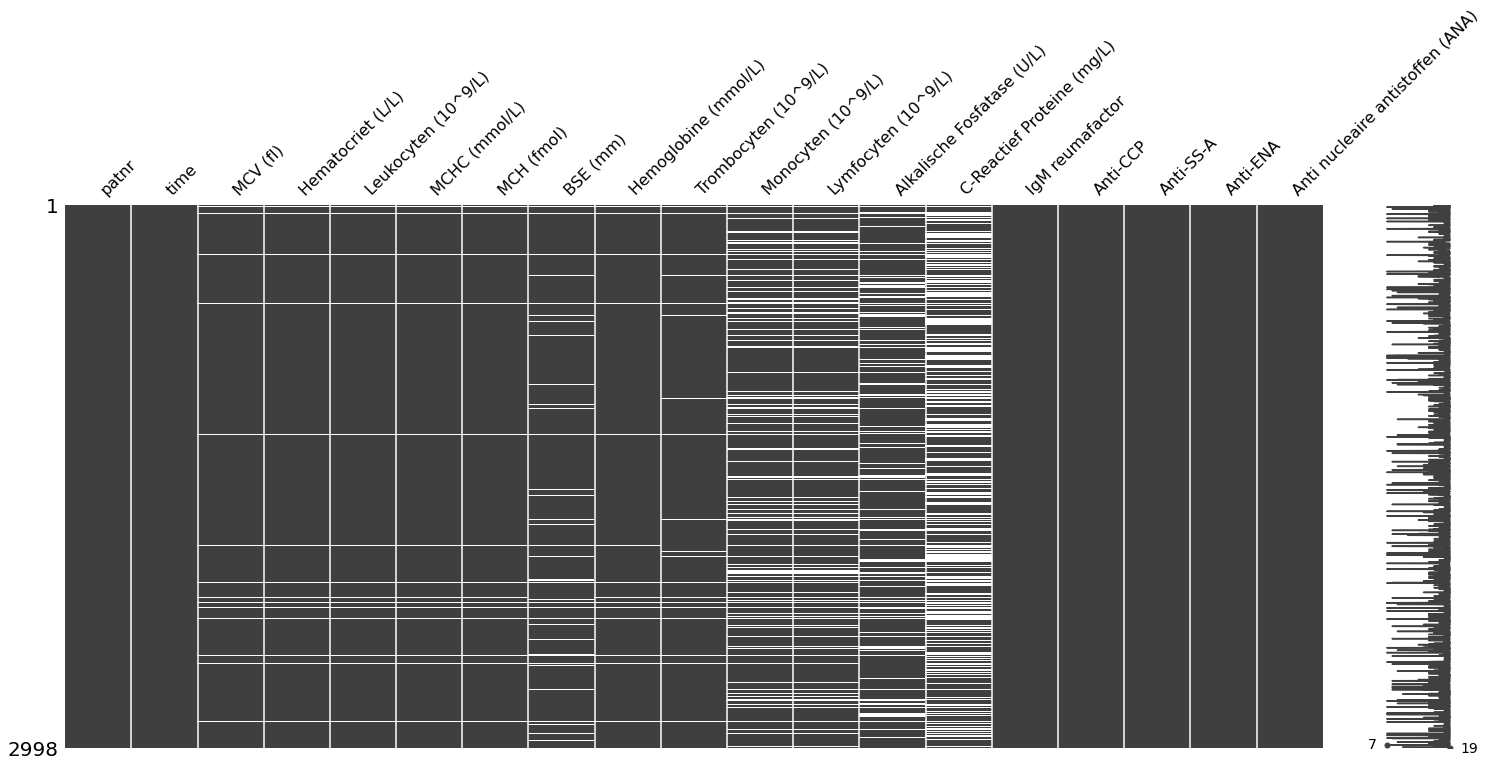

In [44]:
import missingno as msno
%matplotlib inline
msno.matrix(df_new[l_col])

## Check mean probability in cluster

In [51]:
df_pat = pd.read_csv(r'../filters/RA_patients_083.csv', sep=',', index_col=0)
new_pat = dict(zip(df_pat.PATNR, df_pat.PEC))
print(len(new_pat.keys()))
np.mean(df_pat[df_pat['PATNR'].isin(data_trans['patnr'])]['prediction']), np.mean(df_pat[df_pat['PATNR'].isin(data_trans[data_trans['clust']==2.0]['patnr'])]['prediction'])
#data_trans[data_trans['clust']==2.0]['patnr']

1318
